In [1]:
import pandas as pd
import librosa
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import seaborn as sns
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
PATH_RAW_DATAS = "/content/drive/MyDrive/HỆ CSDL DPT(BTL)/data_audio"
PATH_SPLIT_DATAS = "/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio"
PATH_LABELS_FILE = "/content/drive/MyDrive/HỆ CSDL DPT(BTL)/data/data_new.csv"

In [3]:
def get_labels():
  result = os.listdir(PATH_SPLIT_DATAS)
  return result

In [4]:
labels_real = get_labels()
print(len(list(labels_real)))  

10


In [5]:
def log_specgram(audio, sample_rate, window_size=20,step_size=10, eps=1e-10):
  nperseg = int(round(window_size * sample_rate / 1e4))
  noverlap = int(round(step_size * sample_rate / 1e4))
  freqs, times, spec = signal.spectrogram(audio,fs=sample_rate,window='hann',nperseg=nperseg,noverlap=noverlap,detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [6]:
def visualize_wav_form_and_spectrogram(samples, sample_rate,name):
  freqs, times, spectrogram = log_specgram(samples, sample_rate)
  print(spectrogram.shape)
  fig = plt.figure(figsize=(14, 8))
  ax1 = fig.add_subplot(211)
  ax1.set_title('Raw wave of ' + name)
  ax1.set_ylabel('Amplitude')
  ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)

  ax2 = fig.add_subplot(212)
  ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
            extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax2.set_yticks(freqs[::16])
  ax2.set_xticks(times[::16])
  ax2.set_title('Spectrogram of ' + name )
  ax2.set_ylabel('Freqs in Hz')
  ax2.set_xlabel('Seconds')

In [7]:
def get_datas():
  path_folder = PATH_SPLIT_DATAS
  labels_real = get_labels()
  res = []
  for label in labels_real:
    list_audio = glob.glob(pathname=os.path.join(path_folder,label,"*.wav"))
    for file_audio in list_audio:
      signal,sr = librosa.load(path=file_audio,sr = 44100)
      if len(signal) != 3 * 44100 :
        print(file_audio)
      res.append((signal,label))
  return res

In [8]:
datas = get_datas()

/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/205972__ajaysm__daluo-01.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/206023__ajaysm__daluo-04.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222191__ajaysm__daluo-03.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222190__ajaysm__daluo-02.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222192__ajaysm__daluo-05.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222196__ajaysm__daluo-09.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222197__ajaysm__daluo-10.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222195__ajaysm__daluo-08.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222193__ajaysm__daluo-06.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/daluo/222194__ajaysm__daluo-07.wav
/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/audio/m

(3005, 45)


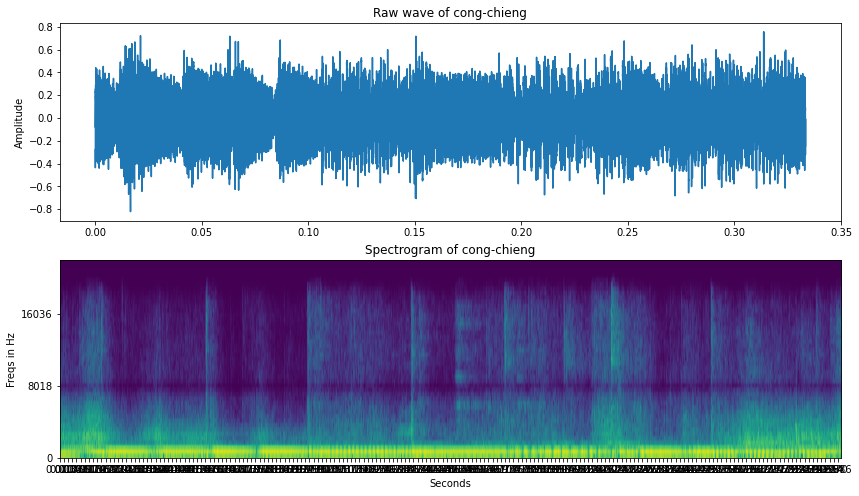

In [9]:
visualize_wav_form_and_spectrogram(datas[10][0],44100,name = datas[10][-1])

In [10]:
def get_zero_crossings(audio):
  zero_crossings = librosa.zero_crossings(audio, pad=False)
  return sum(zero_crossings)

In [11]:
%%time
ZCRS = []
y = []
for item in datas:
  tmp = get_zero_crossings(item[0])
  ZCRS.append([item[-1],tmp])


CPU times: user 30.1 s, sys: 81.3 ms, total: 30.2 s
Wall time: 30.2 s


In [12]:
df = pd.DataFrame(data=ZCRS,columns = ["y","ZCRS"])

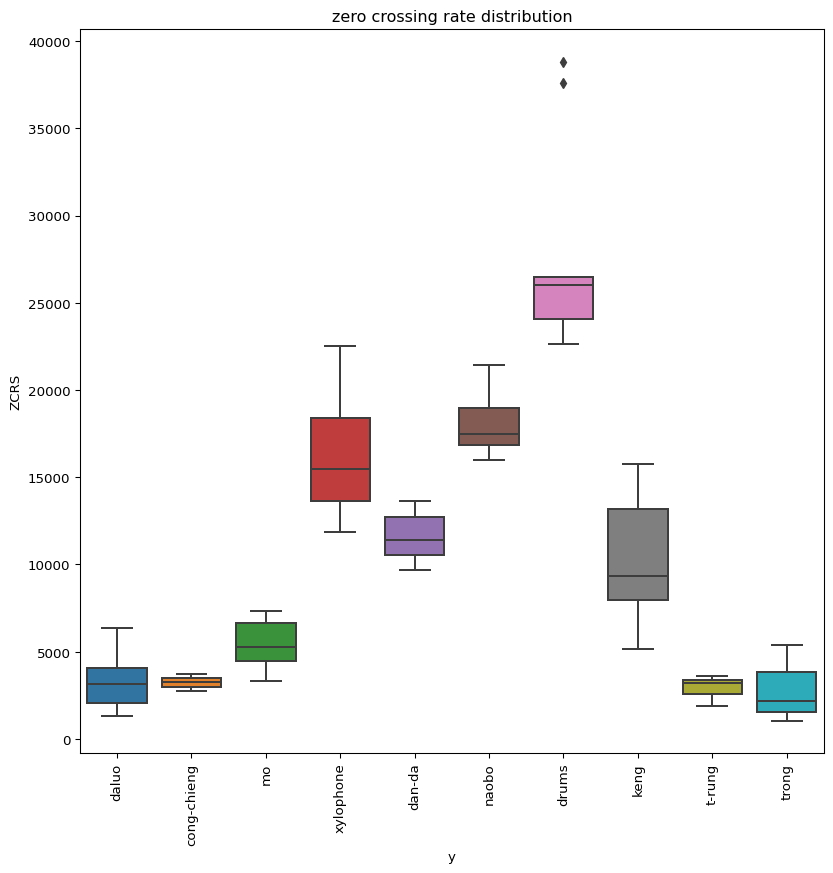

In [13]:
my_dpi = 96
plt.figure(figsize=(10,10), dpi=my_dpi)
sns.boxplot(x="y", y="ZCRS", data=df)
plt.xticks(rotation=90)
plt.title("zero crossing rate distribution")
#plt.savefig(fname = "/content/drive/MyDrive/HỆ CSDL DPT(BTL)/images/zero_crossing_rate_distribution.png", dpi=500)
plt.show()



In [14]:
def draw_labels_distribution(df):
  label_value_counts = df.y.value_counts() 
  sum = 0 
  _x = []
  _values = []
  for item in label_value_counts.index:
    _x.append(item)
    _values.append(label_value_counts[item])
  my_dpi = 96
  plt.figure(figsize=(800/my_dpi + 3, 800/my_dpi+3 ), dpi=my_dpi)
  plt.bar(x=_x,height=_values)
  plt.xlabel("labels")
  plt.ylabel("amount")
  plt.xticks(rotation=90)
  plt.title("labels distribution")
  #plt.savefig(fname = "/content/drive/MyDrive/HỆ CSDL DPT(BTL)/images/labels_distribution.png", dpi=500)
  plt.show()

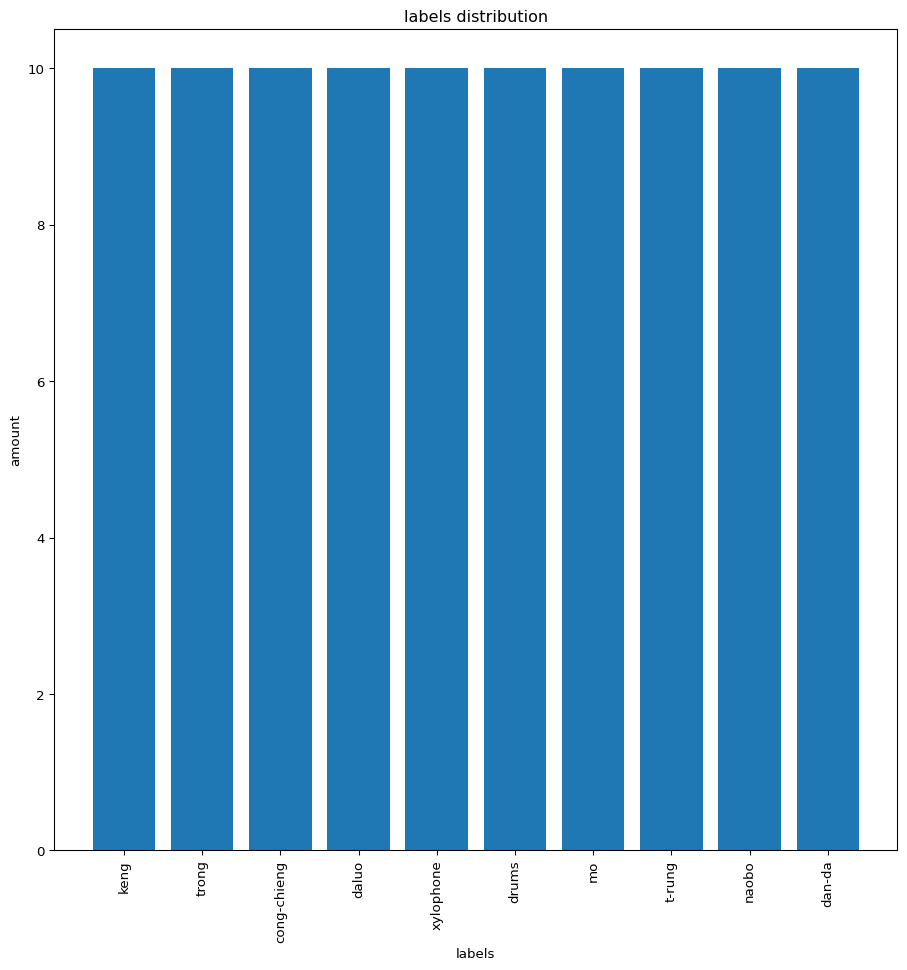

In [15]:
draw_labels_distribution(df)

In [16]:

def amplitude_envelope(signal, frame_size, hop_length):
    amplitude_envelope = []
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)

In [17]:
def visulize_AE(audio,sr,name):
  FRAME_SIZE = 1024
  HOP_LENGTH = 512
  AE = amplitude_envelope(audio,FRAME_SIZE,HOP_LENGTH)
  librosa.display.waveplot(audio, alpha=0.5)
  frames = range(len(AE))
  t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
  plt.plot(t, AE, color="r")
  plt.title(name)


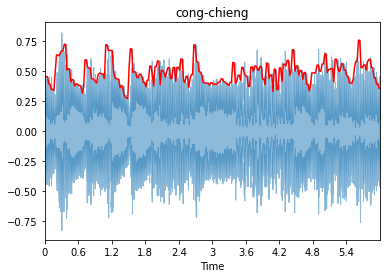

In [18]:
visulize_AE(datas[10][0],44100,datas[10][-1])

In [19]:
def get_mean_AE(signal, frame_size, hop_length):
  res = amplitude_envelope(signal, frame_size, hop_length)
  return res.mean()

In [20]:
def get_mean_AES(datas):
  frame_size = 1024
  hop_length = 512
  res = []
  for item in datas:
    res.append(get_mean_AE(item[0],frame_size,hop_length))
  return res
 

In [21]:
df["AE"] = get_mean_AES(datas)

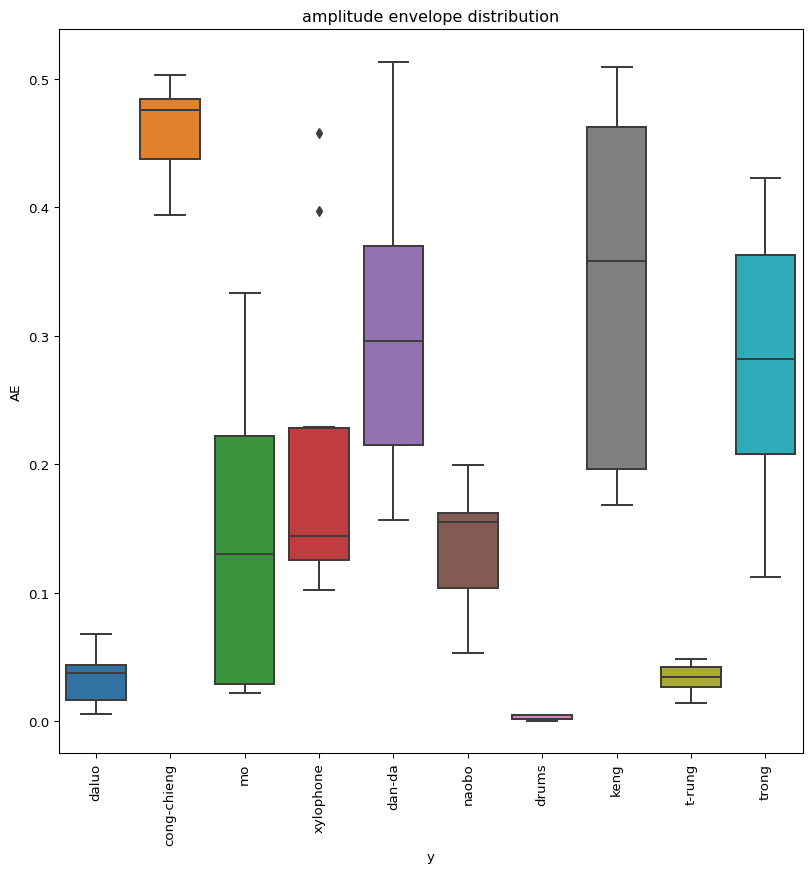

In [22]:
plt.figure(figsize=(10,10), dpi=my_dpi)
sns.boxplot(x="y", y="AE", data=df)
plt.xticks(rotation=90)
plt.title("amplitude envelope distribution")
plt.show()

In [23]:
def get_sum_delta__AE(signal, frame_size, hop_length):
  res = amplitude_envelope(signal, frame_size, hop_length)
  return (np.diff(res, n=1)**2).sum()

In [24]:
def sum_delta__AES(datas):
  frame_size = 1024
  hop_length = 512
  res = []
  for item in datas:
    res.append(get_sum_delta__AE(item[0],frame_size,hop_length))
  return res

In [25]:
df["sum_delta__AE"] = sum_delta__AES(datas)

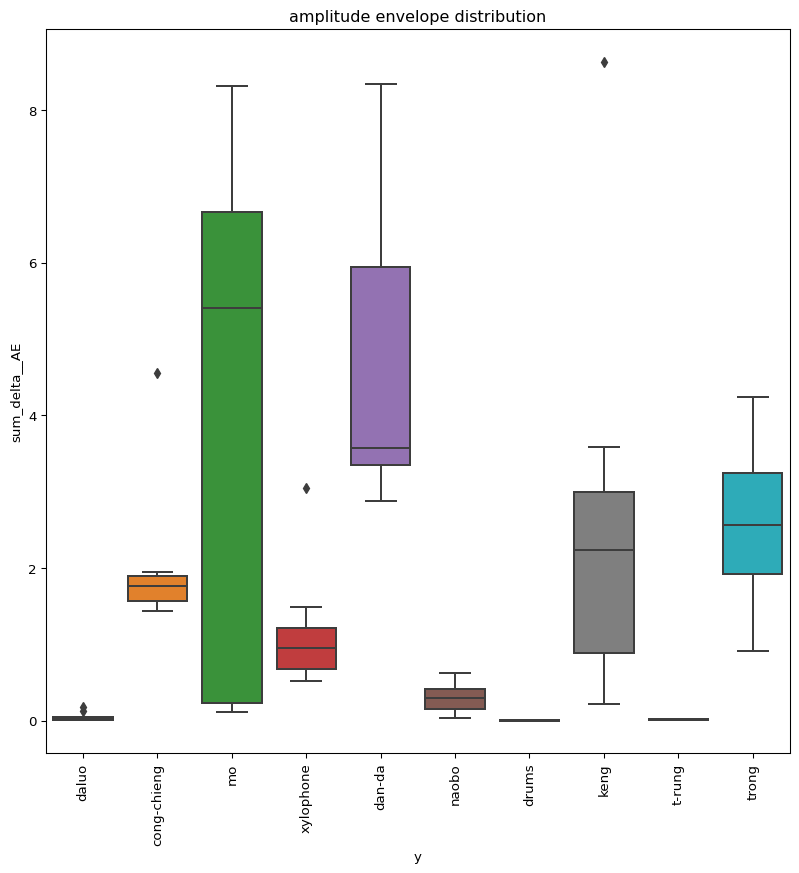

In [26]:
plt.figure(figsize=(10,10), dpi=my_dpi)
sns.boxplot(x="y", y="sum_delta__AE", data=df)
plt.xticks(rotation=90)
plt.title("amplitude envelope distribution")
plt.show()

In [27]:
def pad_0(signal):
  if signal.shape[0] < 3*44100:
    number_pad = 3*44100 - signal.shape[0]
    pad = np.zeros(number_pad)
    return np.concatenate([signal,pad])
  else:
    return signal[:3*44100] 

In [28]:
def custom_fft(y, fs):
  y = pad_0(y)
  T = 5.0 / fs
  N = y.shape[0]
  N =  min(44100//2,N//2)
  yf = fft(y)
  vals =  np.abs(yf[0:N])
  return vals

In [29]:

def visualize_mean_FFT(datas):
  vals_all = {}
  for item in datas:
    vals = custom_fft(item[0], 44100)
    freqs, times, spec = log_specgram(item[0], 44100)
    if item[-1] in vals_all :
      vals_all[item[-1]].append(vals)
    else:
      vals_all[item[-1]] = []
      vals_all[item[-1]].append(vals)
  for key in vals_all:
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + key)
    plt.plot(np.mean(np.array(vals_all[key]), axis=0))
    # plt.yticks(freqs[::16])
    # plt.xticks(times[::16])
    plt.show()

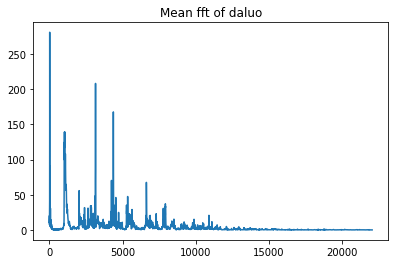

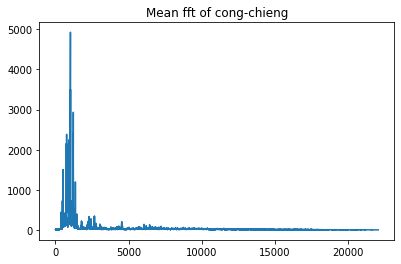

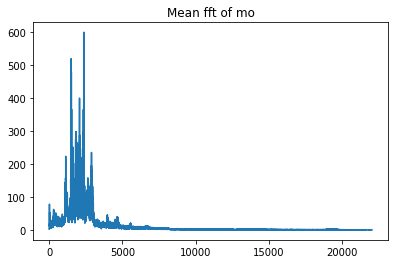

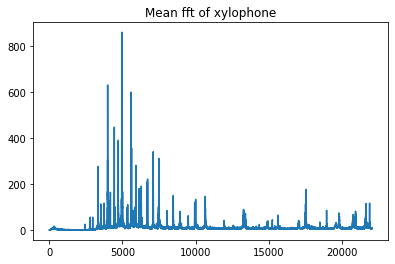

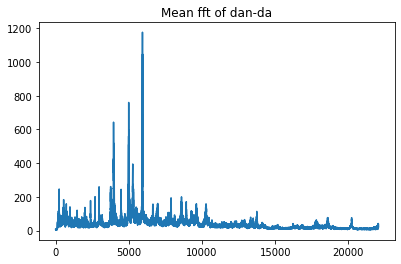

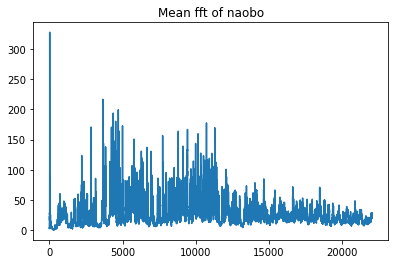

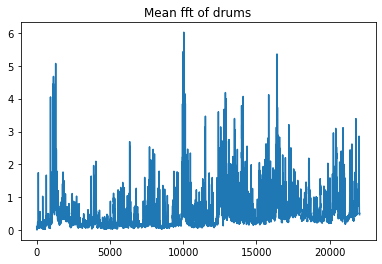

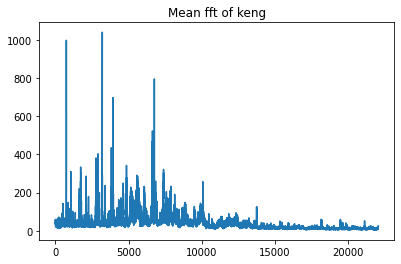

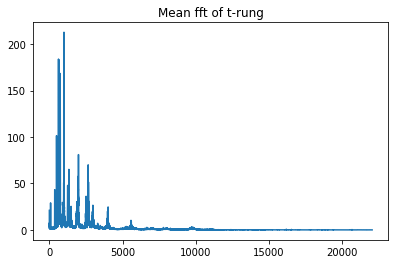

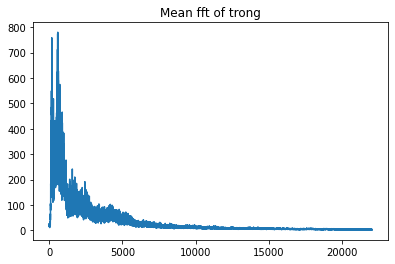

In [30]:
visualize_mean_FFT(datas)

In [31]:

def visualize_histogram_FFT(datas):
  vals_all = {}
  for item in datas:
    vals = custom_fft(item[0], 44100)
    if item[-1] in vals_all :
      vals_all[item[-1]].append(vals)
    else:
      vals_all[item[-1]] = []
      vals_all[item[-1]].append(vals)
  for key in vals_all:
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('histogram fft of ' + key)
    
    plt.hist(np.log(np.mean(np.array(vals_all[key]), axis=0)),bins=64)
    # plt.yticks(freqs[::16])
    # plt.xticks(times[::16])
    plt.show()

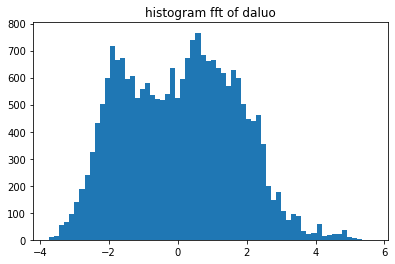

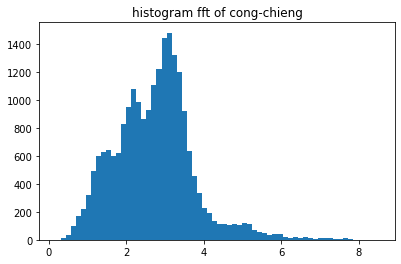

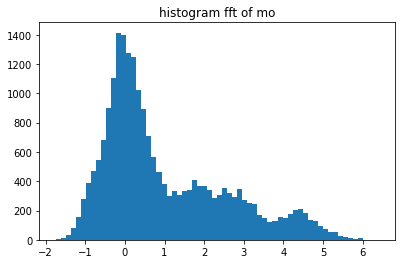

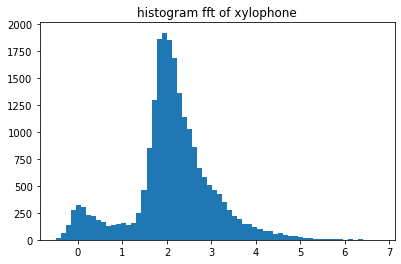

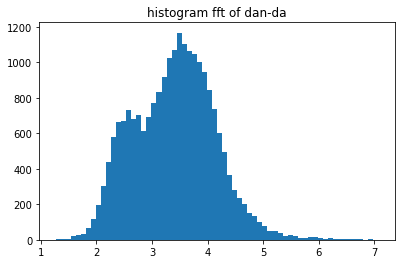

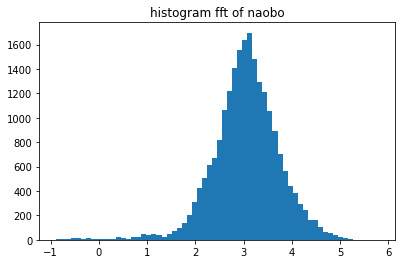

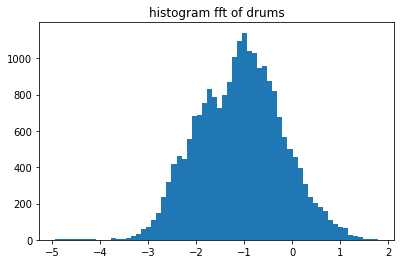

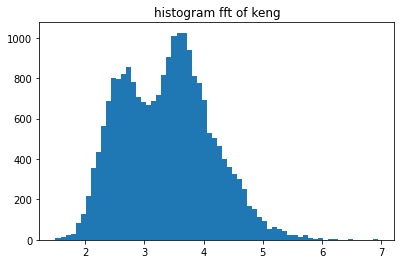

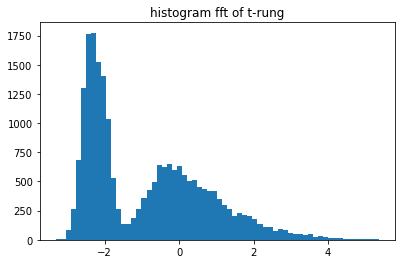

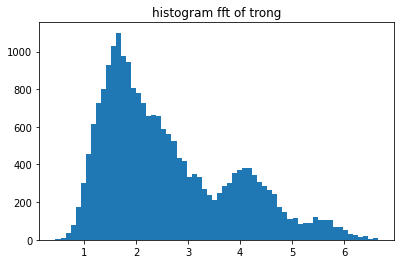

In [32]:
visualize_histogram_FFT(datas)

In [120]:
def filter_frequenly(audio,sr):
  vals = custom_fft(audio, sr)
  res = []
  res.append(vals[20:22].mean())
  res.append(vals[22:25].mean())
  res.append(vals[25:30].mean())
  res.append(vals[30:40].mean())
  res.append(vals[40:50].mean())
  res.append(vals[50:60].mean())
  res.append(vals[70:80].mean())
  res.append(vals[80:90].mean())
  res.append(vals[100:120].mean())
  res.append(vals[120:140].mean())
  res.append(vals[140:160].mean())
  res.append(vals[160:180].mean())
  res.append(vals[180:200].mean())
  res.append(vals[200:250].mean())
  res.append(vals[250:300].mean())
  res.append(vals[300:350].mean())
  res.append(vals[350:400].mean())
  res.append(vals[400:450].mean())
  res.append(vals[450:500].mean())
  res.append(vals[500:600].mean())
  res.append(vals[600:700].mean())
  res.append(vals[700:800].mean())
  res.append(vals[800:1000].mean())
  res.append(vals[1000:1200].mean())
  res.append(vals[1200:2000].mean())
  res.append(vals[2000:3000].mean())
  res.append(vals[3000:4000].mean())
  res.append(vals[4000:7000].mean())
  res.append(vals[7000:15000].mean())
  res.append(vals[15000:].mean())
  print(len(res))
  return res

In [121]:
def get_histogram(audio ,sr):
    vals = custom_fft(audio, sr)
    return list(np.histogram(np.log(vals+0.00001),bins=64)[0])

In [122]:
def get_delta__AE(signal, frame_size, hop_length):
  signal =  pad_0(signal)
  res = amplitude_envelope(signal, frame_size, hop_length)
  return list((np.diff(res, n=1)**2))

In [123]:
def get_mean_AE(signal, frame_size, hop_length):
  res = amplitude_envelope(signal, frame_size, hop_length)
  return [res.mean()]

In [124]:
def get_zero_crossings(audio):
  zero_crossings = librosa.zero_crossings(audio, pad=False)
  return [sum(zero_crossings)]

In [131]:
def creat_data_set(datas):
  cols = ["label","ZCR","Mean_AE"]
  #for i in range(258):
  #  cols += ["delta_"+str(i)]

  for i in range(30):
    cols += ["filter"+str(i)]
  HOP_LENGTH = 512
  FRAME_SIZE = 1024
  res = []
  for item in datas:
    tmp = [item[-1]]
    tmp += get_zero_crossings(item[0])
    tmp += get_mean_AE(item[0],FRAME_SIZE,HOP_LENGTH)
    tmp += filter_frequenly(item[0],44100)
    #tmp += get_delta__AE(item[0],FRAME
    res.append(tmp)
  df = pd.DataFrame(data=res,columns=cols)
  return df
    
  
  


In [132]:
df = creat_data_set(datas)

30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30


In [133]:
df.head()

,label,ZCR,Mean_AE,filter0,filter1,filter2,filter3,filter4,filter5,filter6,filter7,filter8,filter9,filter10,filter11,filter12,filter13,filter14,filter15,filter16,filter17,filter18,filter19,filter20,filter21,filter22,filter23,filter24,filter25,filter26,filter27,filter28,filter29
0,daluo,2072,0.034504,71.423676,109.870728,118.688393,20.904230,26.054409,9.960115,12.221117,5.045804,9.063908,7.520451,5.668507,1.874305,1.858691,1.628459,0.484654,0.685851,1.392074,1.035590,1.097893,1.204575,1.585877,1.961473,2.255553,133.214661,17.462784,13.539022,15.644541,18.088926,6.626722,0.714431
1,daluo,6352,0.067785,32.874279,76.504158,128.726456,15.520187,18.907597,15.928022,13.820623,5.991253,8.089955,8.696195,5.644499,2.082375,1.577907,1.987206,0.771788,0.899646,0.930403,0.890139,0.623775,0.687812,0.710131,1.185629,3.082441,138.903580,3.568070,9.590879,13.855521,14.874176,3.907134,0.469672
2,daluo,1292,0.010455,81.346183,84.630260,103.033340,13.163855,21.464772,6.967148,12.270742,7.275624,9.601327,6.863997,4.586059,2.030435,1.331214,1.379681,0.781762,0.773970,0.859226,0.700689,0.494861,0.623541,0.674806,1.085797,2.553653,12.975176,1.480451,2.209660,1.021334,0.344695,0.058258,0.015087
3,daluo,2086,0.037191,55.043003,132.627243,113.968460,18.768147,17.129923,12.588006,11.587197,8.987156,5.953629,6.666008,4.612819,1.753617,1.657306,1.534390,0.423087,0.622978,1.094218,0.876276,0.801469,0.778236,0.725288,1.779742,3.693802,133.946960,28.383804,18.794788,19.329222,16.833912,7.778152,0.877536
4,daluo,4117,0.038075,35.475677,98.375000,110.572739,12.316706,15.814557,14.453929,10.625223,6.191136,6.142879,8.522454,5.475122,2.042015,1.558168,1.907616,0.748567,0.668462,0.729848,0.836221,0.760822,0.731494,0.562174,0.705126,2.545147,85.869621,1.958083,9.178984,9.285763,4.920530,0.906880,0.056758


In [134]:
labelencoder = LabelEncoder()
df["label"] = labelencoder.fit_transform(df['label'])

In [135]:
X =  df.drop(["label"],axis=1).values

In [136]:
y = df["label"].values

In [137]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [145]:

def random_forest(X_train,y_train,X_test,y_test):
  import pickle
  from sklearn.metrics import confusion_matrix
  clf = RandomForestClassifier(n_estimators=200)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(confusion_matrix(y_test, y_pred))
  print("acc random_forest = {} %".format(accuracy_score(y_test, y_pred) * 100))
  filename = '/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/model/random_forest_model.sav'
  pickle.dump(clf, open(filename, 'wb'))
  return accuracy_score(y_test, y_pred)


In [146]:

random_forest(X_train,y_train,X_test,y_test)

[[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 4 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 3 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 4]]
acc random_forest = 93.93939393939394 %


0.9393939393939394

In [147]:
def KNN(X_train,y_train,X_test,y_test):
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  print("acc KNN = {} %".format(accuracy_score(y_test, y_pred) * 100))
  return accuracy_score(y_test, y_pred)


In [148]:
def naive_bayes(X_train,y_train,X_test,y_test):
  clf = MultinomialNB()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("acc naive_bayes = {} %".format(accuracy_score(y_test, y_pred) * 100))
  return accuracy_score(y_test, y_pred)


In [149]:
def decision_tree(X_train,y_train,X_test,y_test):
  clf = tree.DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_train)
  print("acc decision_tree = {} %".format(accuracy_score(y_train, y_pred) * 100))
  return accuracy_score(y_train, y_pred)


In [150]:
def gradient_boosting_classifier(X_train,y_train,X_test,y_test):
  clf = GradientBoostingClassifier(n_estimators=200)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("acc gradient_boosting_classifier = {} %".format(accuracy_score(y_test, y_pred) * 100))
  return accuracy_score(y_test, y_pred)


In [151]:
KNN(X_train,y_train,X_test,y_test)
naive_bayes(X_train,y_train,X_test,y_test)
decision_tree(X_train,y_train,X_test,y_test)
random_forest(X_train,y_train,X_test,y_test)
gradient_boosting_classifier(X_train,y_train,X_test,y_test)

acc KNN = 63.63636363636363 %
acc naive_bayes = 87.87878787878788 %
acc decision_tree = 100.0 %
[[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 4 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 3 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 4]]
acc random_forest = 93.93939393939394 %
acc gradient_boosting_classifier = 78.78787878787878 %


0.7878787878787878

In [152]:
print(labelencoder.inverse_transform([9]))

['xylophone']


In [153]:
from sklearn.model_selection import cross_val_score


In [154]:
clf = RandomForestClassifier(n_estimators=200,criterion="entropy")
scores = cross_val_score(clf, X, y, cv=5)


In [155]:
scores

array([0.95, 0.9 , 0.95, 0.95, 0.9 ])

In [156]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.93 accuracy with a standard deviation of 0.02


In [157]:
df.to_csv("/content/drive/MyDrive/Hệ cơ sở dữ liệu DPT/data/data.csv",index=False)